# Урок 2. Keras

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras.datasets import fashion_mnist

# Практическое задание

Используем набор примеров fashion-MNIST

1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [2]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

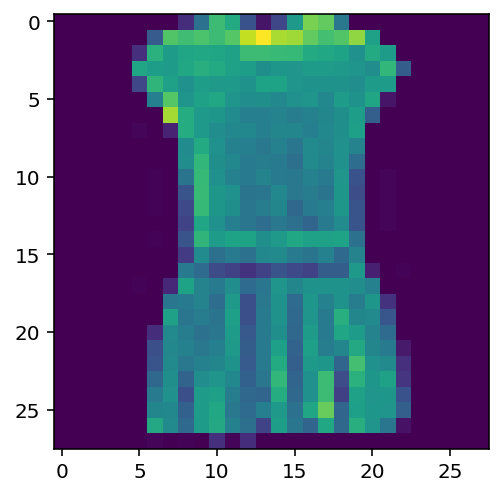

In [3]:
plt.imshow(train_images[3,:,:])
plt.show()

In [4]:
# Normalize the images.
train_images = (train_images / 127) - 1
test_images = (test_images / 127) - 1

# Flatten the images.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

print(train_images.shape)
print(test_images.shape)

(60000, 784)
(10000, 784)


In [5]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Создание модели

Разное число нейронов при двух слоях

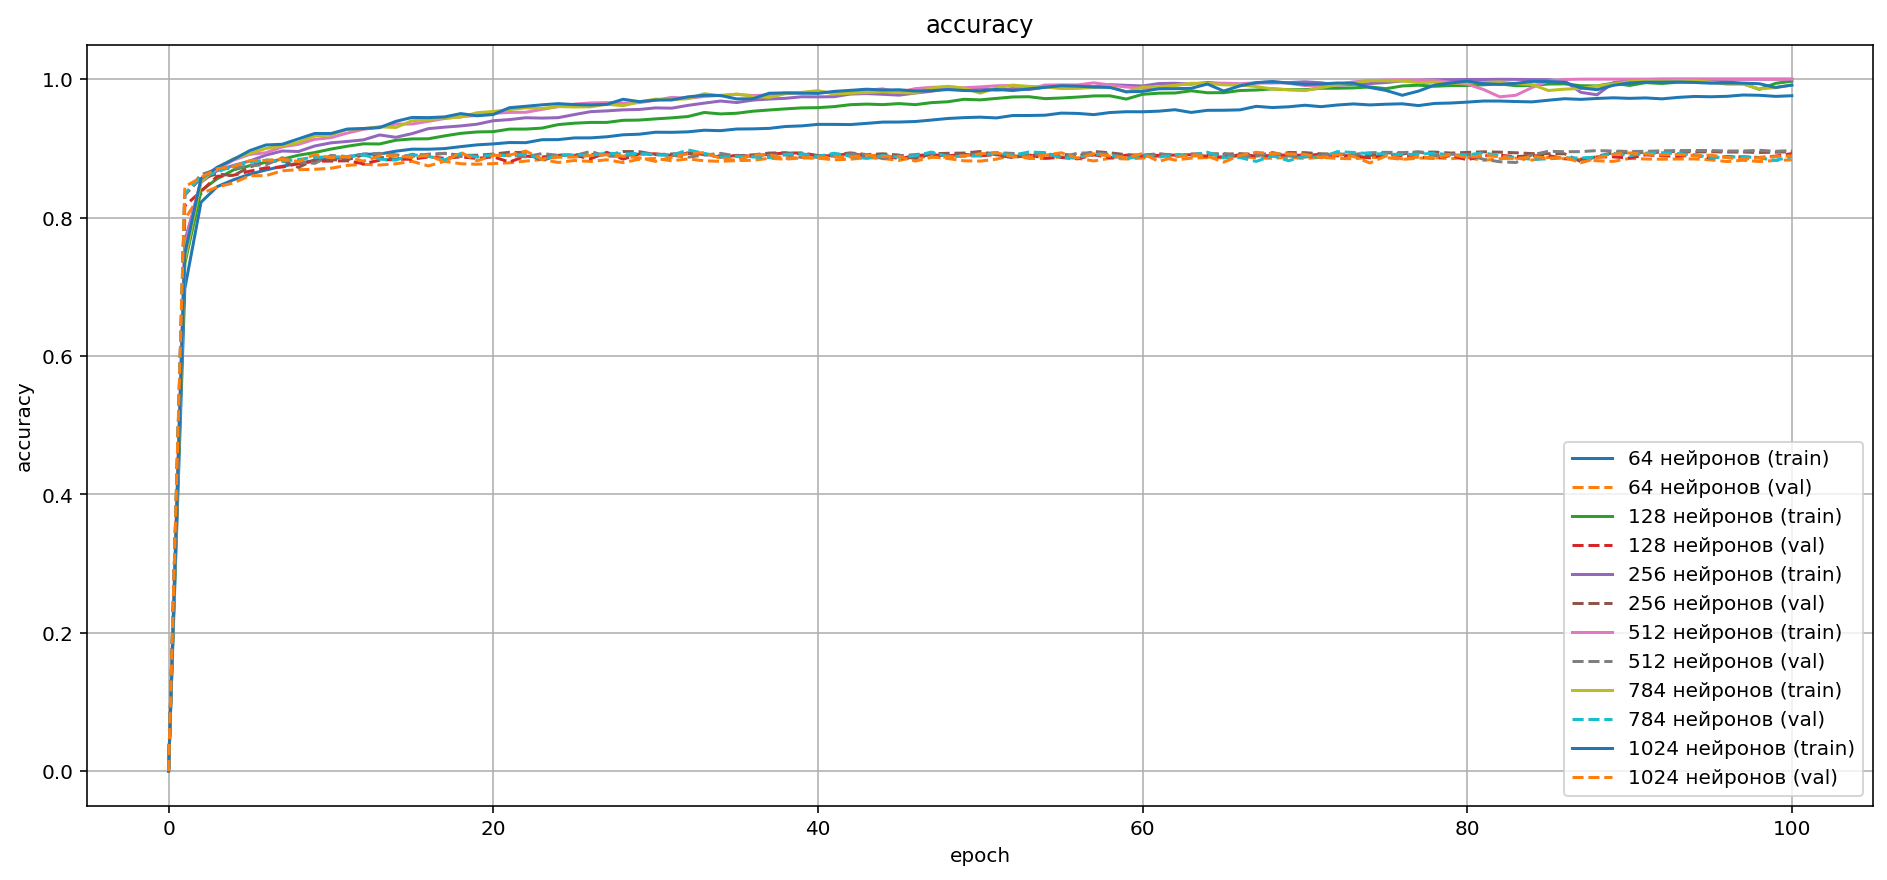

Wall time: 5min 42s


In [6]:
%%time 
neurons = [64, 128, 256, 512, 784, 1024]

plt.figure(figsize=(16,7))

for neuron in neurons:

    # создаем модель model
    modeli = Sequential([
                          Dense(neuron, activation='relu', input_shape=(784,)),
                          Dense(neuron, activation='tanh'),
                          Dense(10, activation='softmax'),
                          ])

    # число рабочих эпох
    epochs = 100
    # вектор для вывода результатов
    epoch = np.arange(epochs+1)

    modeli.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    # вычисляем ошибку для modeli без обучения
    hh0_tr = modeli.evaluate(train_images[:48000,:], to_categorical(train_labels[:48000]),verbose = 0)
    hh0_val = modeli.evaluate(train_images[48000:,:], to_categorical(train_labels[48000:]),verbose = 0)
    # проводим обучение модели 
    hh = modeli.fit(
        train_images,
        to_categorical(train_labels),
        epochs=epochs,
        batch_size=1024, validation_split=0.2, verbose = 0
    )

    # картинки
    plt.plot(epoch,[0]+hh.history['accuracy'],'-',label = str(neuron) +' нейронов (train)')
    plt.plot(epoch,[0]+hh.history['val_accuracy'],'--',label = str(neuron) +' нейронов (val)')
    plt.legend()
    plt.grid('On')

plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


Наблюдение: Увеличение числа нейронов не дает сильного прироста на валидации. Увеличение числа нейронов скорее больше влияет на скорость переобучения модели на трейне. 128 нейронов и 20 эпох обучения выглядит вполне достаточным.

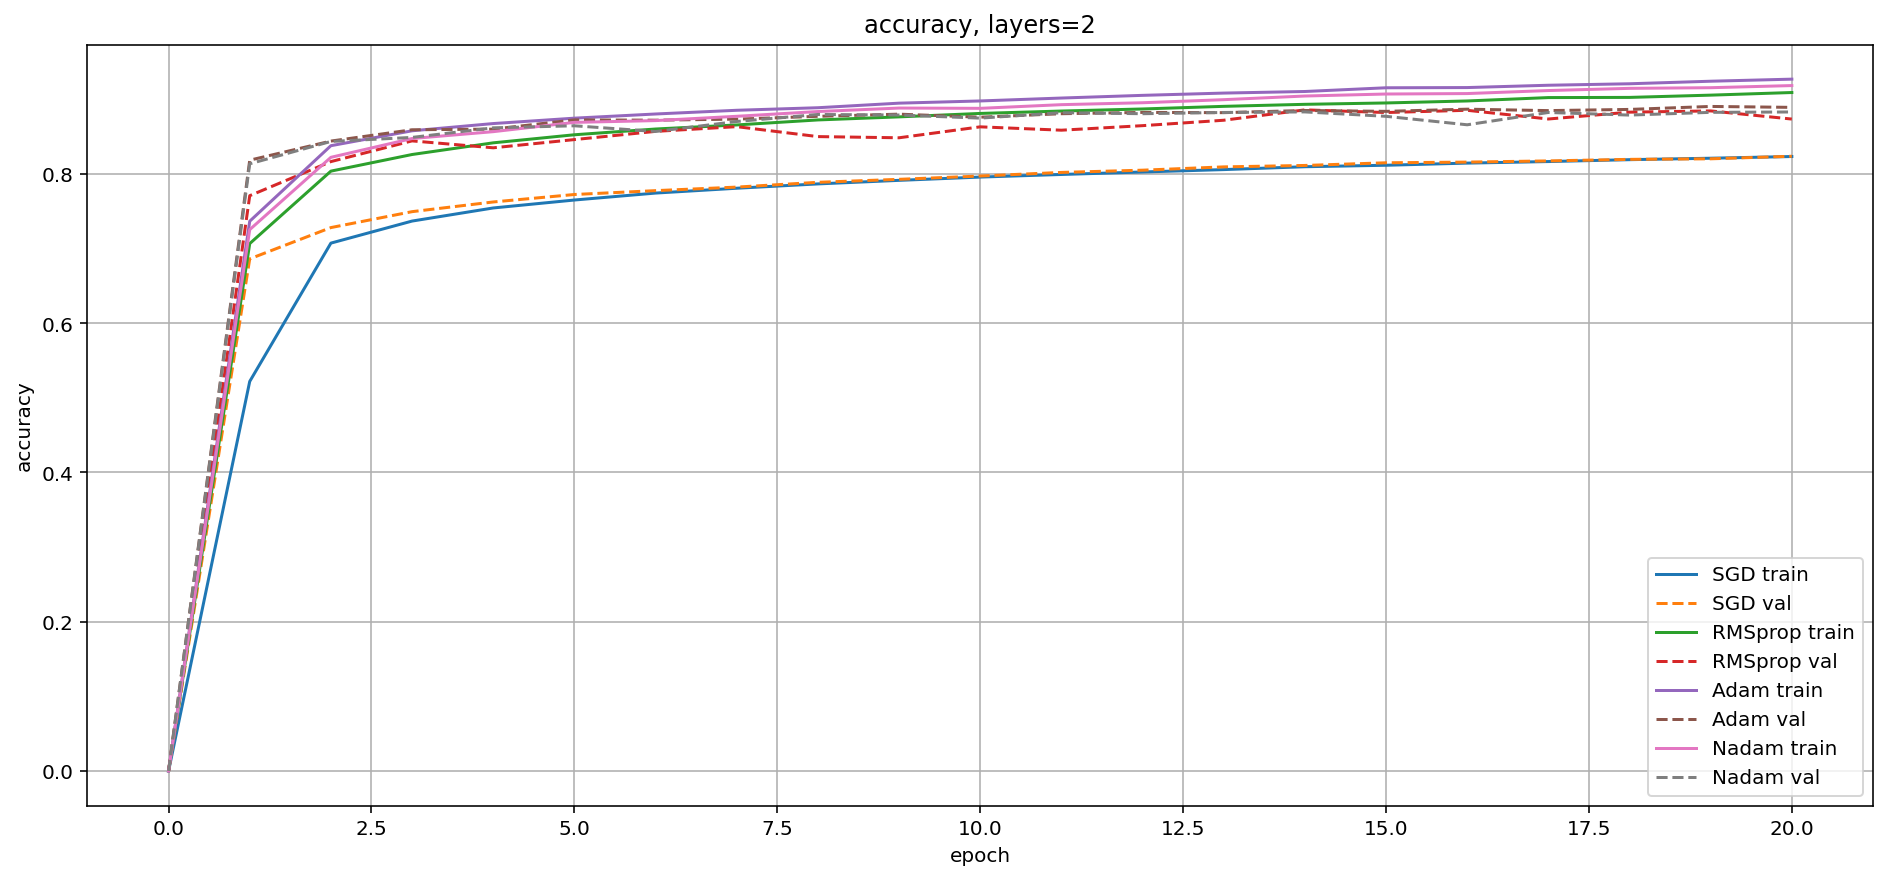

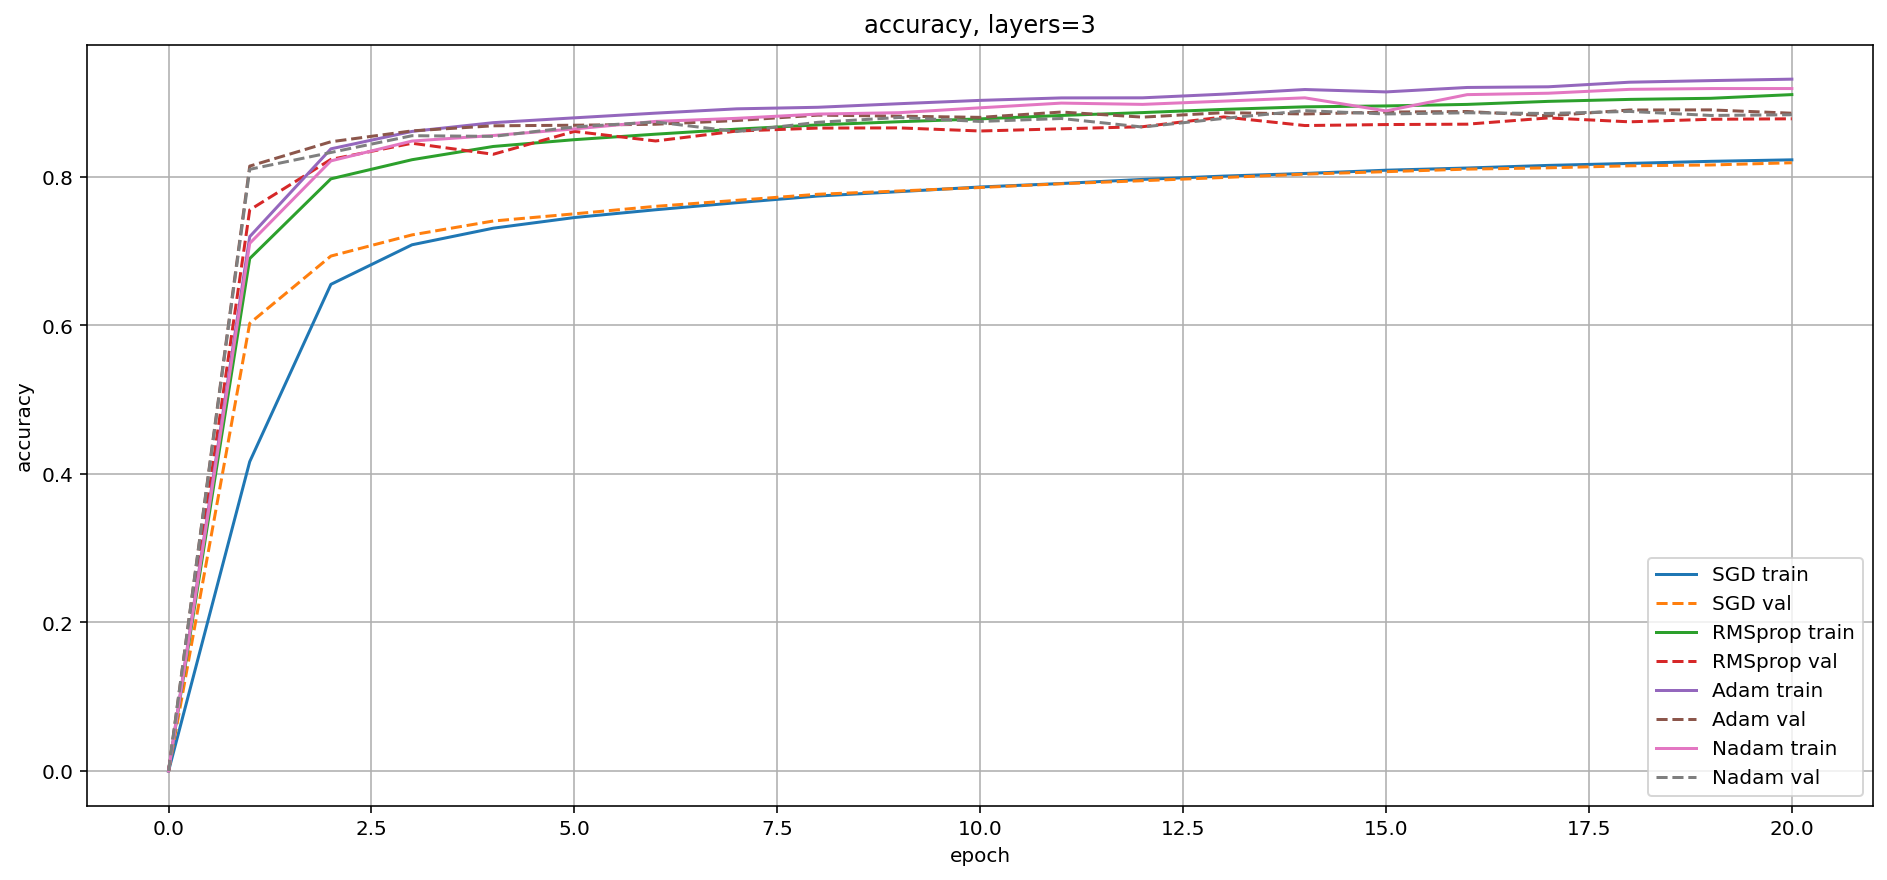

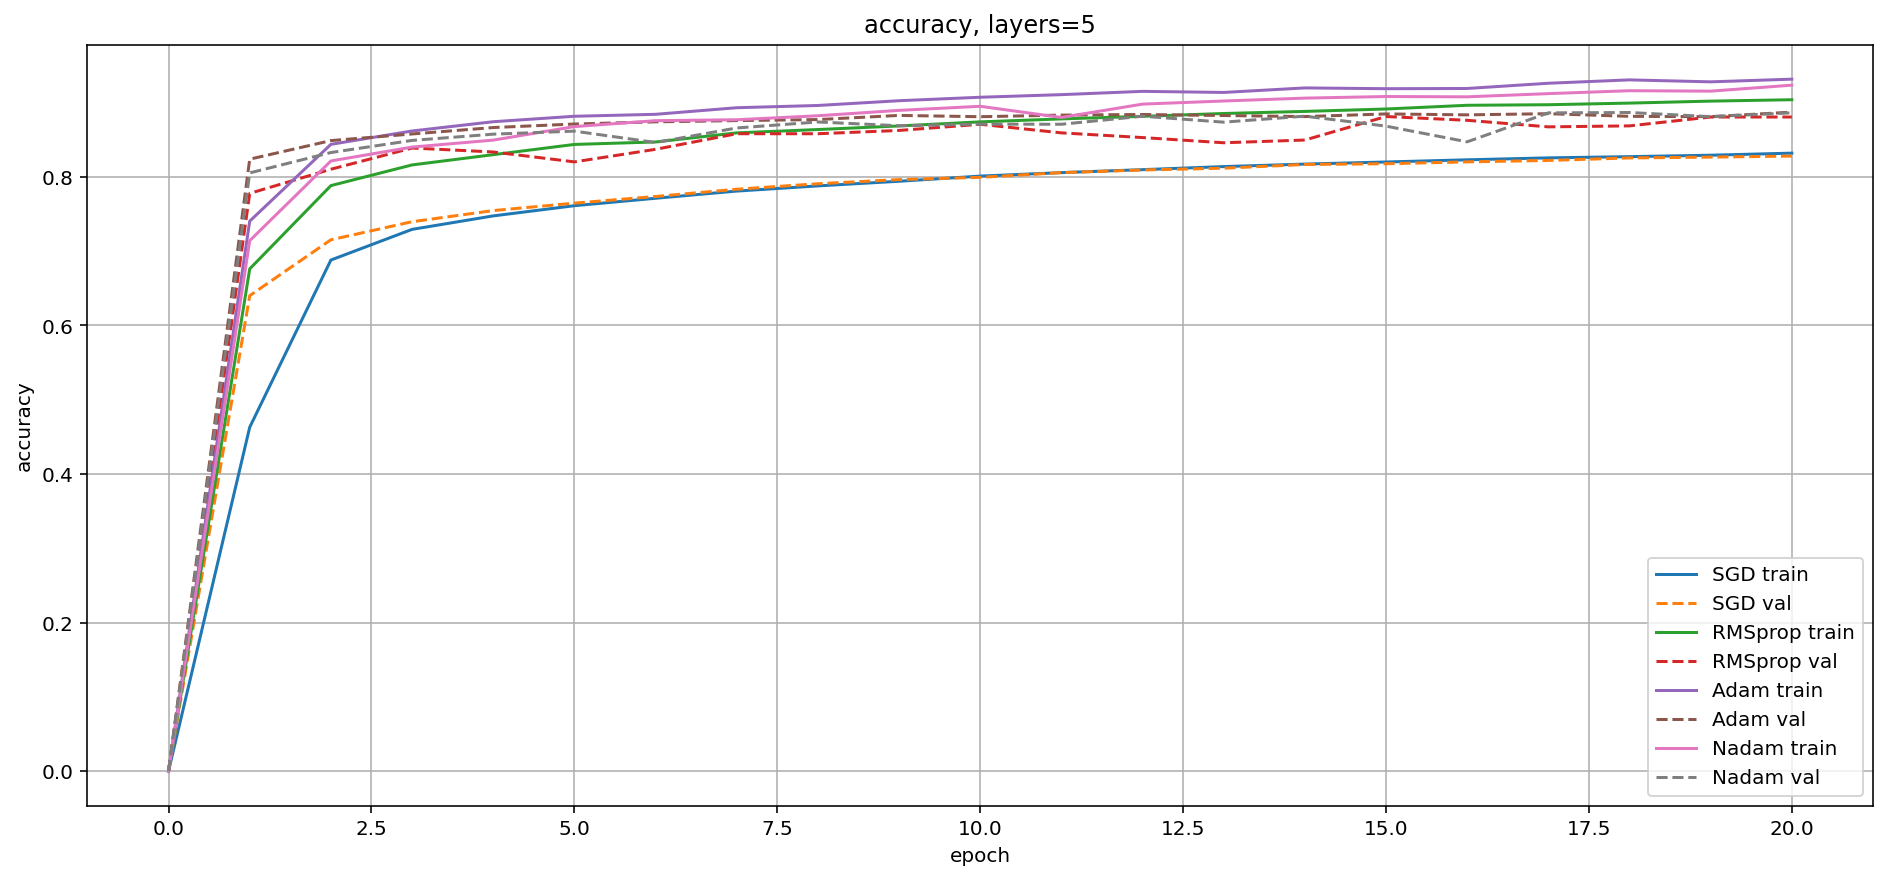

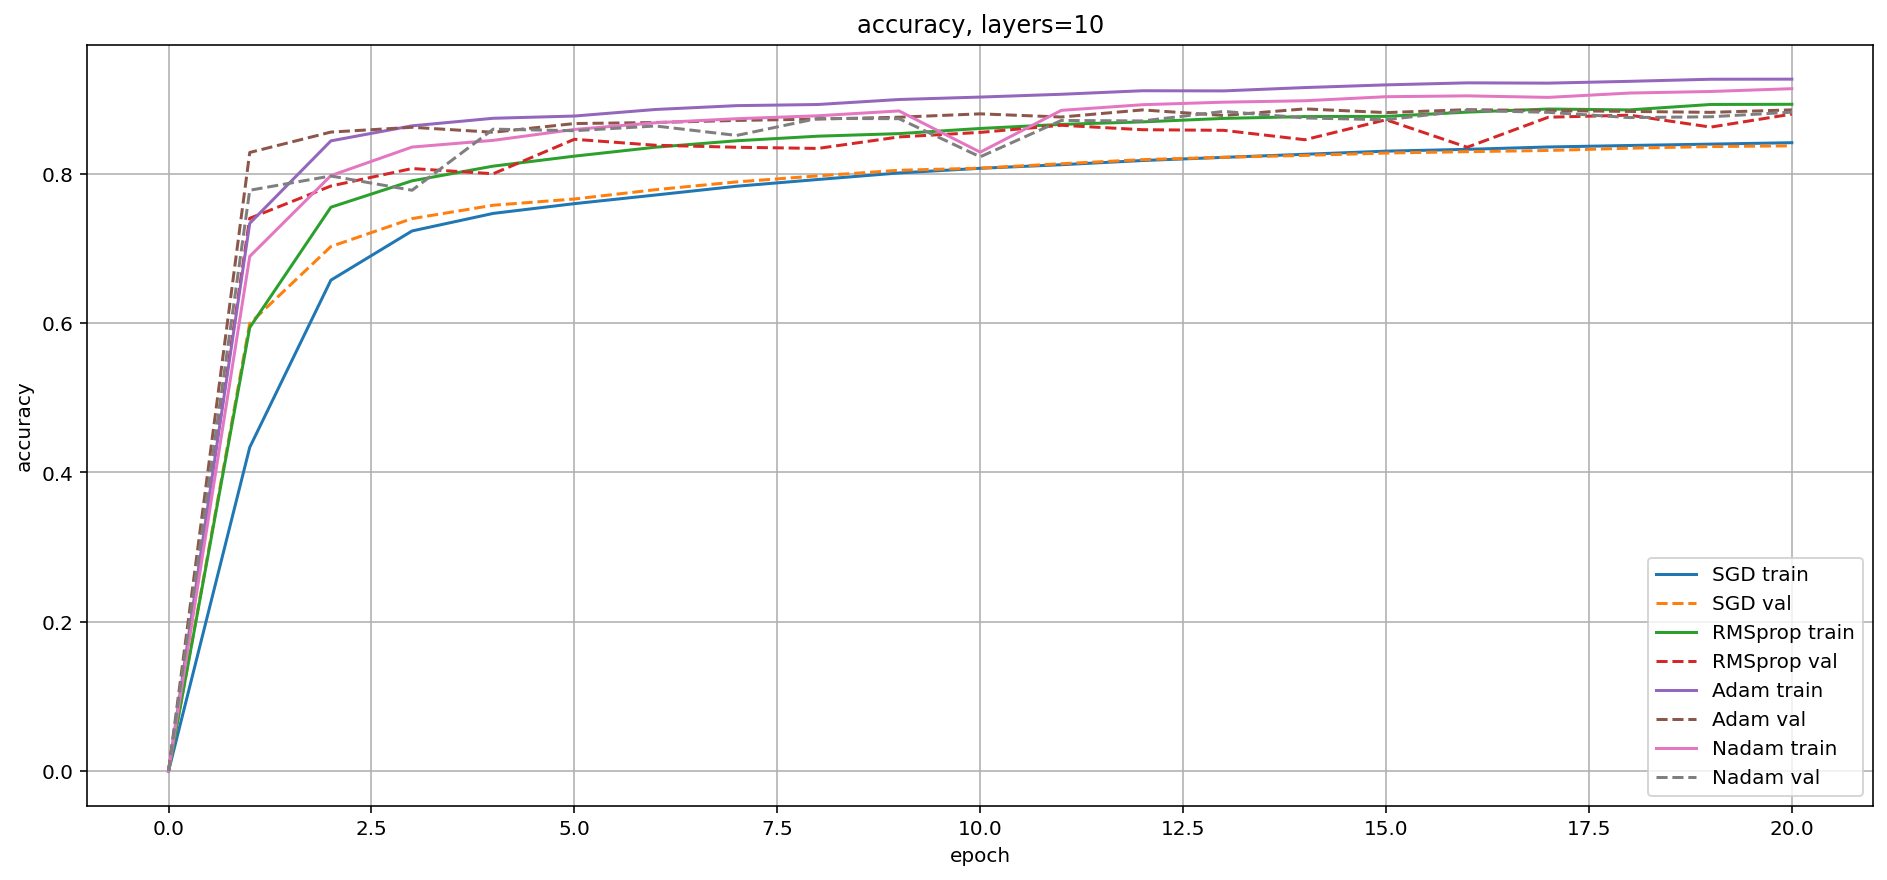

Wall time: 1min 42s


In [7]:
%%time 
layers = [2, 3, 5, 10]
for l in layers:
    
    model = Sequential(name='my_model')
    model.add( Dense( 128, activation='relu', input_shape=(784,)))  
    for k in range(l-1):
      model.add(Dense(128, activation='tanh')) 
    model.add(Dense(10, activation='softmax')) 

    # сохраняем ее веса (это начальная точка) model.save_weights('model.h5')
    model.save_weights(f'{l}model.h5')

    plt.figure(figsize=(16,7))

    # число рабочих эпох
    epochs = 20
    
    # вектор для выводв результатов
    epoch = np.arange(epochs+1)

    #opt_list = [keras.optimizers.SGD( ),keras.optimizers.Adam( ),keras.optimizers.Nadam( )]
    for i_optim in ['SGD','RMSProp','adam','NAdam']:
        # создаем рабочую модель modeli куда будем загружать эти вес (она должна быть идентичной структуры)
        modeli = Sequential(name='my_model')
        modeli.add( Dense(128, activation='relu', input_shape=(784,)))  
        for k in range(l-1):
          modeli.add(Dense(128, activation='tanh')) 
        modeli.add(Dense(10, activation='softmax')) 
        
      
        # загружаем веса modeli.load_weights('model.h5')
        modeli.load_weights(f'{l}model.h5')
        # компилируем modeli с одним из оптимизаторов
        modeli.compile(
            optimizer=i_optim,
            loss='categorical_crossentropy',
            metrics=['accuracy'],
        )

        # проводим обучение модели 
        hh = modeli.fit(
                      train_images,
                      to_categorical(train_labels),
                      epochs=epochs,
                      batch_size=1024, validation_split=0.2, verbose = 0
                      )
        # картинки
        plt.plot(epoch,[0]+hh.history['accuracy'],'-',
                 label = modeli.optimizer.get_config()['name']+' train')
        plt.plot(epoch,[0]+hh.history['val_accuracy'],'--',
                 label = modeli.optimizer.get_config()['name']+' val')
    plt.legend()
    plt.grid('On')

    plt.title('accuracy, layers='+str(l))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

Наблюдение: увеличение числа слоев ситуацию принципиально не улучшает. Оптимизатор SGD отработал хуже всего во всех вариантах. Похоже, что оптимизатор adam показывает наболее оптимальные результаты на 2 и 3 слоях.

Попробуем 3 слоя, где последний слой будет с разным числом нейтронов

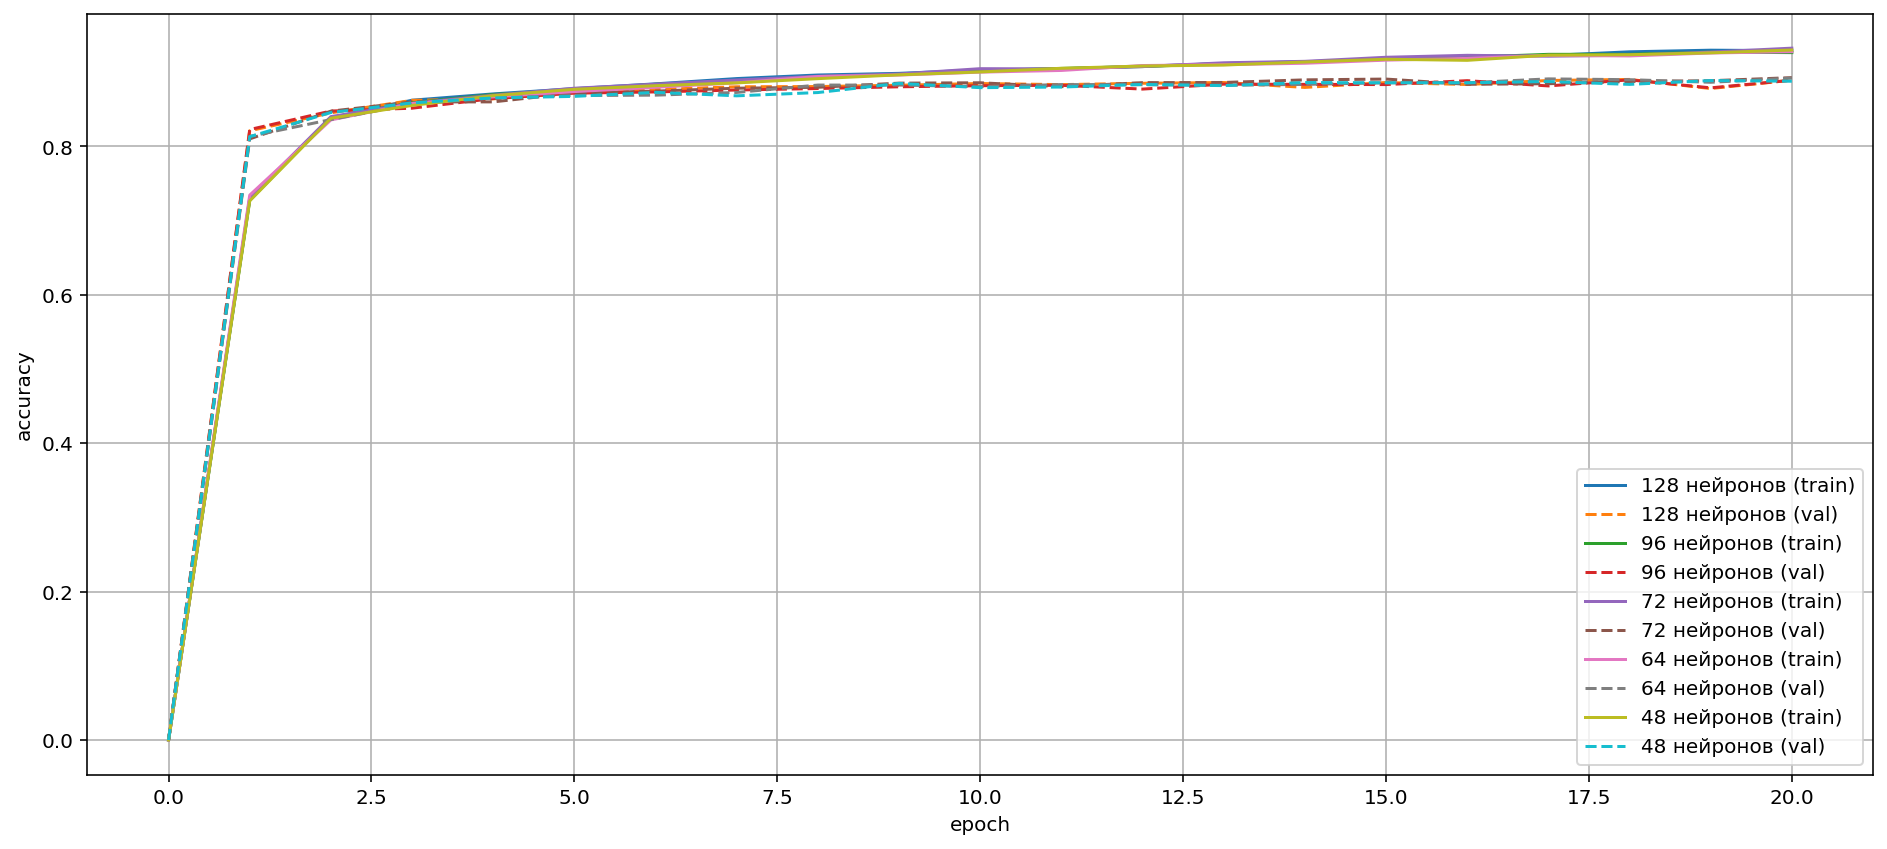

Wall time: 25.7 s


In [8]:
%%time 
inner_neurons = [128, 96, 72, 64, 48]

plt.figure(figsize=(16,7))

for neuron in inner_neurons:

    # создаем модель model
    modeli = Sequential([
                          Dense(128, activation='relu', input_shape=(784,)),
                          Dense(128, activation='tanh'),
                          Dense(neuron, activation='tanh'),
                          Dense(10, activation='softmax'),
                          ])

    # число рабочих эпох
    epochs = 20
    # вектор для вывода результатов
    epoch = np.arange(epochs+1)

    modeli.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    # проводим обучение модели 
    hh = modeli.fit(
        train_images,
        to_categorical(train_labels),
        epochs=epochs,
        batch_size=1024, validation_split=0.2, verbose = 0
    )

    # картинки
    plt.plot(epoch,[0]+hh.history['accuracy'],'-',label = str(neuron) +' нейронов (train)')
    plt.plot(epoch,[0]+hh.history['val_accuracy'],'--',label = str(neuron) +' нейронов (val)')
    plt.legend()
    plt.grid('On')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Наблюдение: никакой разницы

Оставим 2 слоя и попробуем разные функции активации последнего слоя

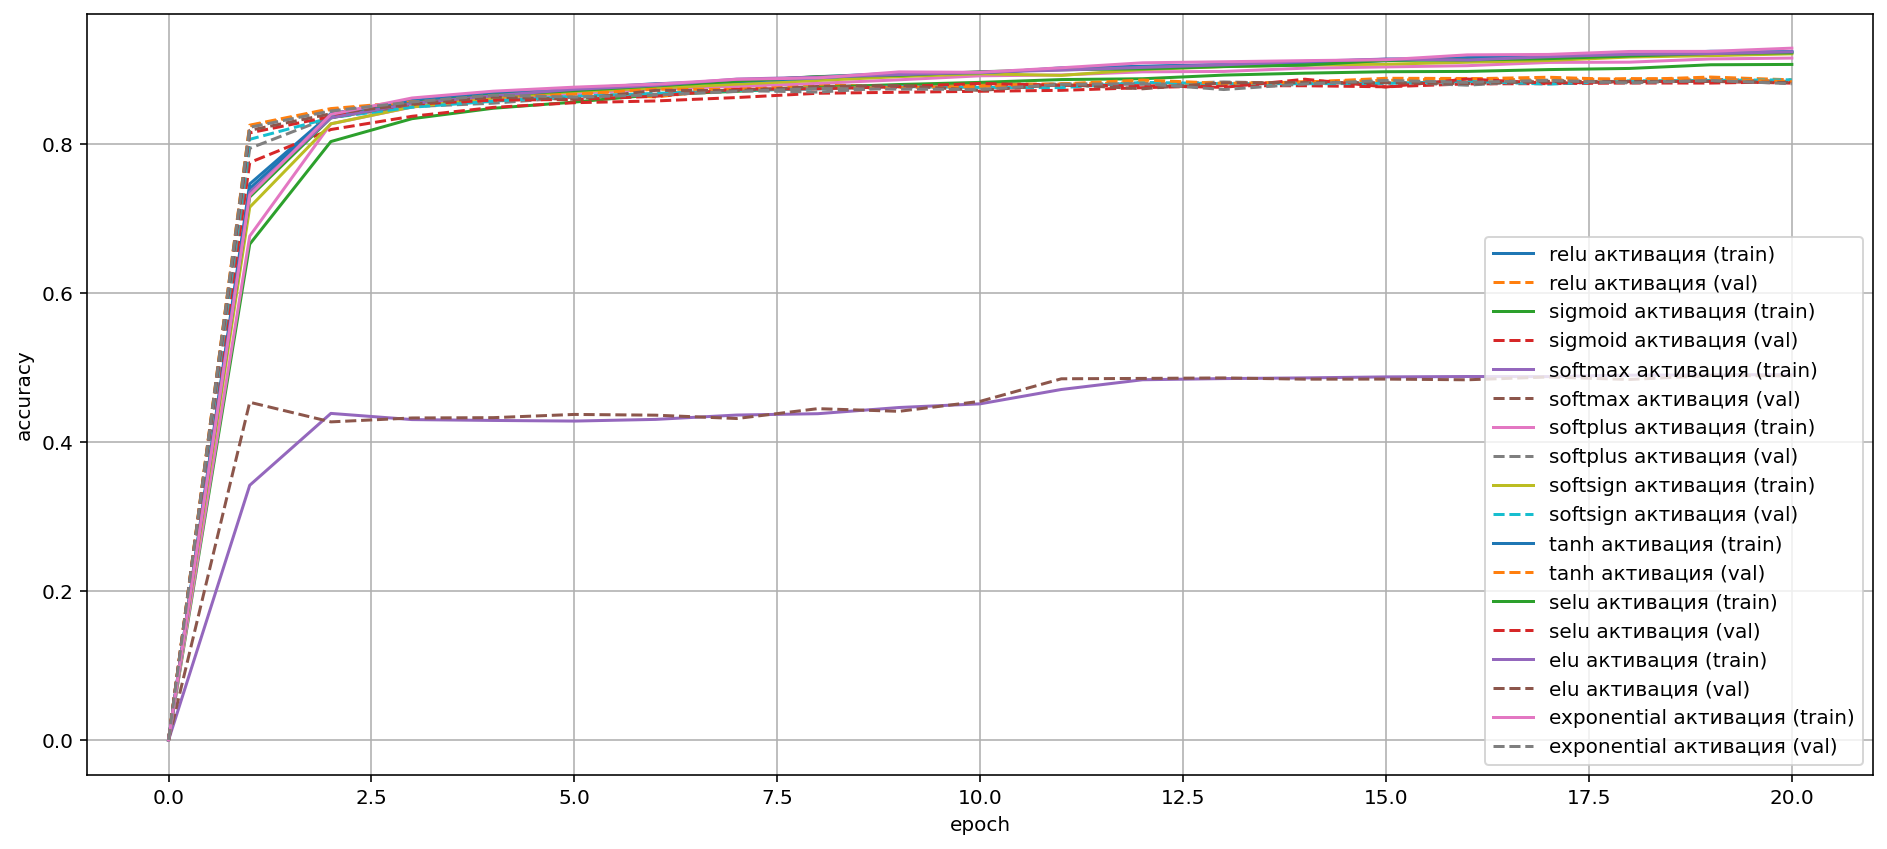

Wall time: 46 s


In [9]:
%%time 
activations = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']

plt.figure(figsize=(16,7))

for act in activations:

    # создаем модель model
    modeli = Sequential([
                          Dense(128, activation='relu', input_shape=(784,)),
                          Dense(128, activation=act),
                          Dense(10, activation='softmax'),
                          ])

    # число рабочих эпох
    epochs = 20
    # вектор для вывода результатов
    epoch = np.arange(epochs+1)

    modeli.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    # проводим обучение модели 
    hh = modeli.fit(
        train_images,
        to_categorical(train_labels),
        epochs=epochs,
        batch_size=1024, validation_split=0.2, verbose = 0
    )

    # картинки
    plt.plot(epoch,[0]+hh.history['accuracy'],'-',label = str(act) +' активация (train)')
    plt.plot(epoch,[0]+hh.history['val_accuracy'],'--',label = str(act) +' активация (val)')
    plt.legend()
    plt.grid('On')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Наблюдение: все, кроме elu отработало примерно одинаково :-/

### Финальная модель

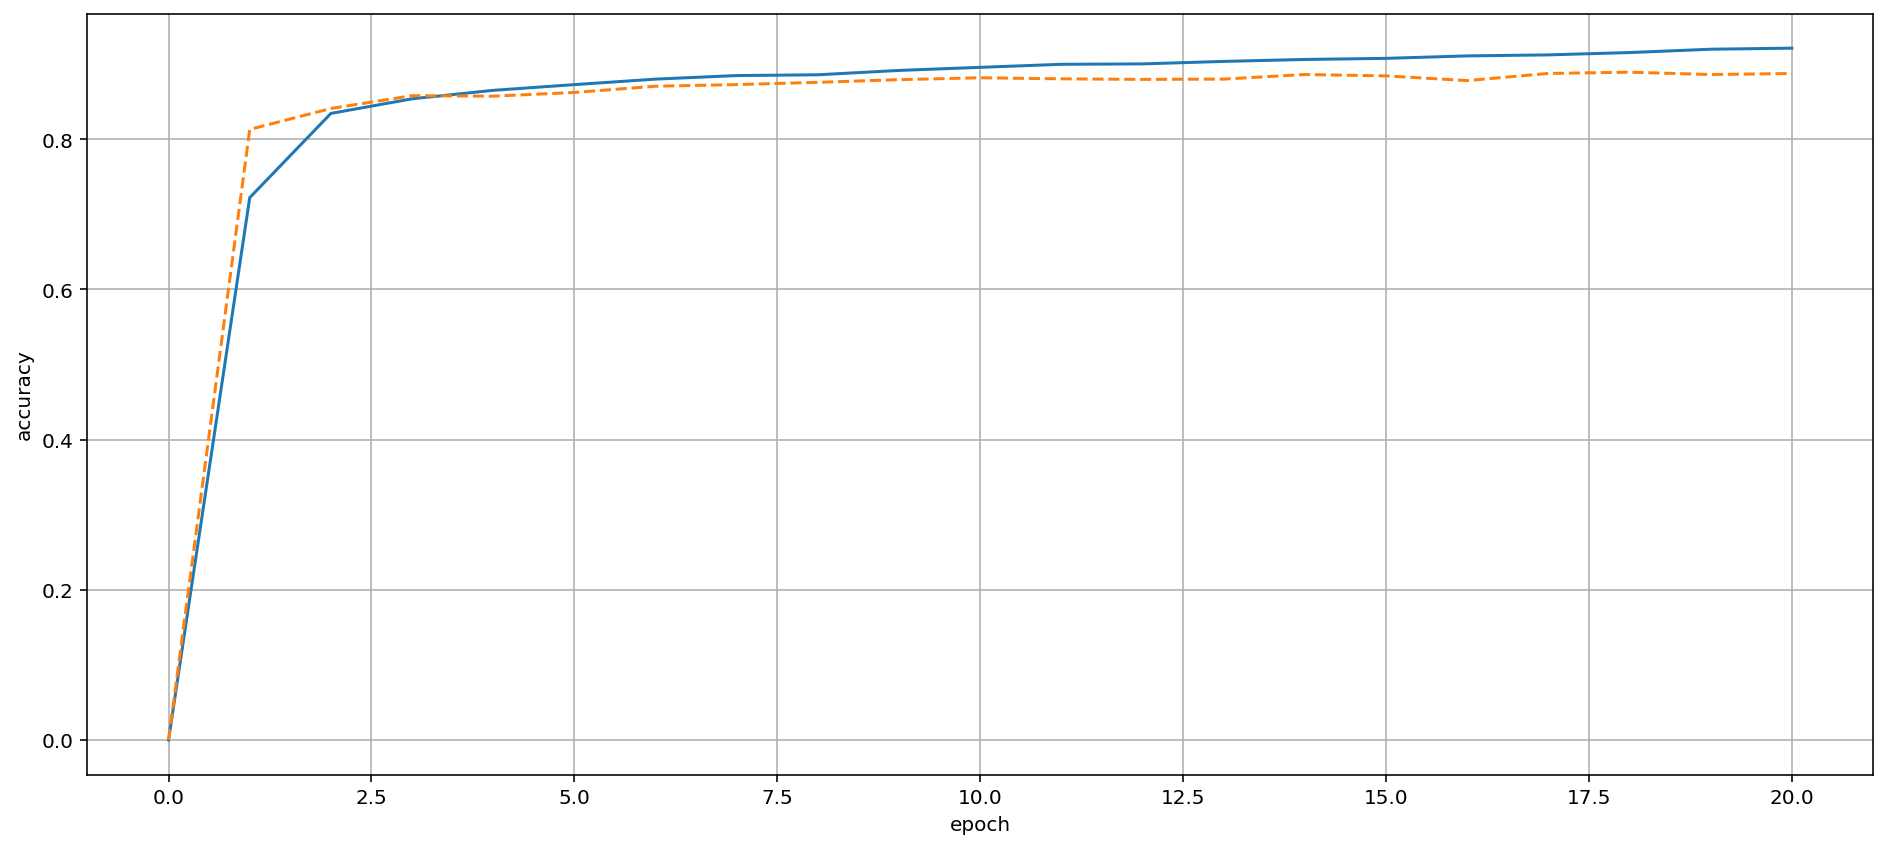

Wall time: 5.23 s


In [10]:
%%time 

model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(128, activation='tanh'),
    Dense(10, activation='softmax'),
])

epochs = 20
epoch = np.arange(epochs+1)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# проводим обучение модели 
hh = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=1024, validation_split=0.2, verbose = 0
)

plt.figure(figsize=(16,7))
plt.plot(epoch,[0]+hh.history['accuracy'],'-')
plt.plot(epoch,[0]+hh.history['val_accuracy'],'--')
plt.grid('On')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [11]:
predicts = model.predict(test_images)

313/313 [==============================] - 0s 783us/step


In [17]:
y_pred_class = np.argmax(predicts,axis=1)

<AxesSubplot:>

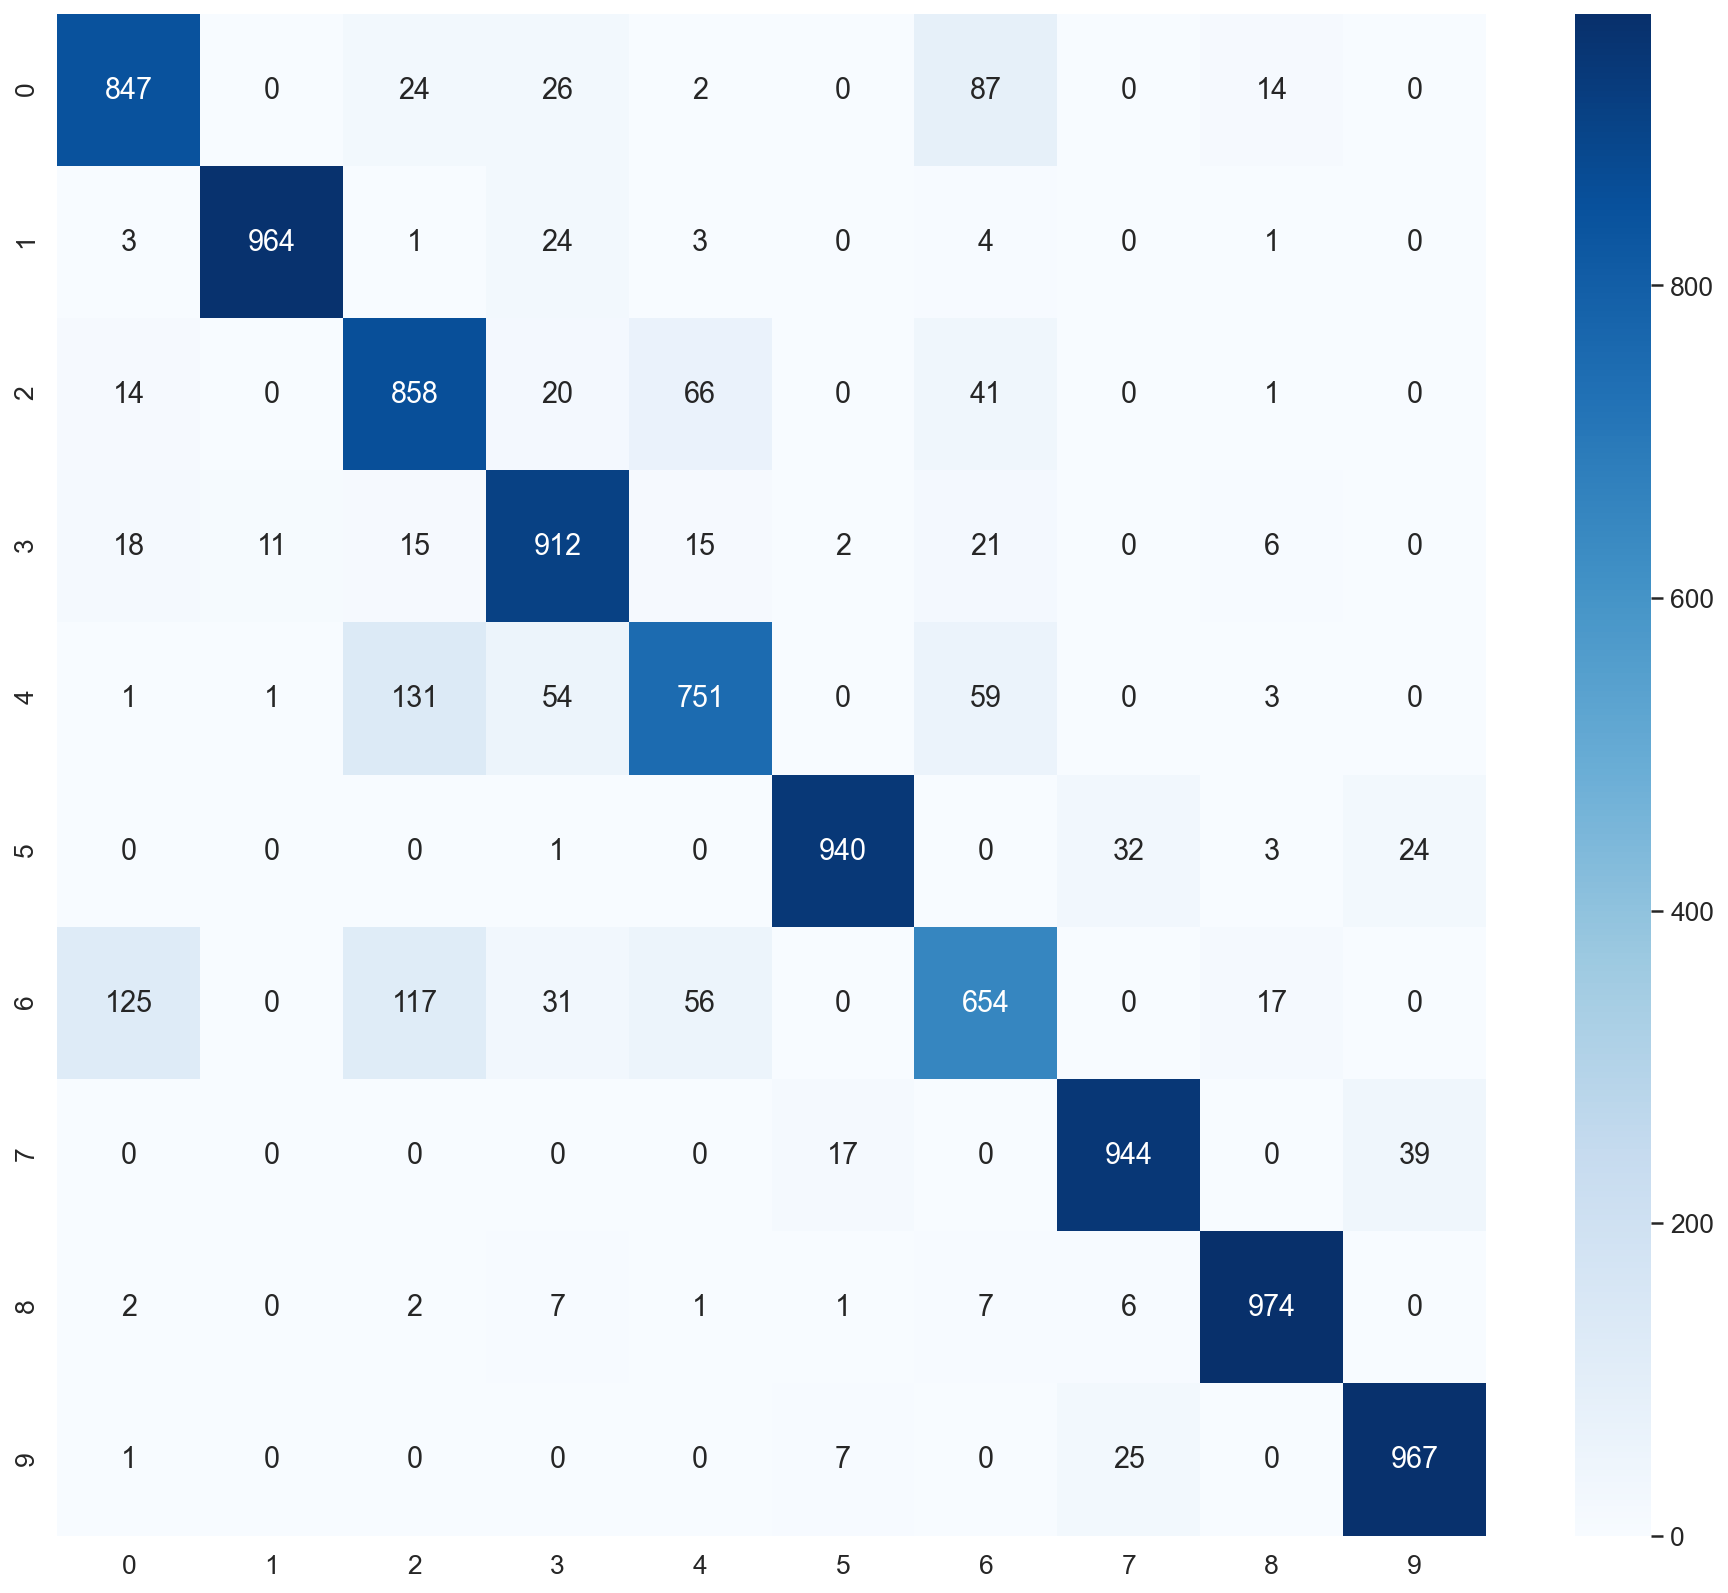

In [37]:
cf_matrix = confusion_matrix(test_labels, y_pred_class)
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(16,14))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

Наблюдение: явно какие-то проблемы с предсказанием 6 и 4 классов

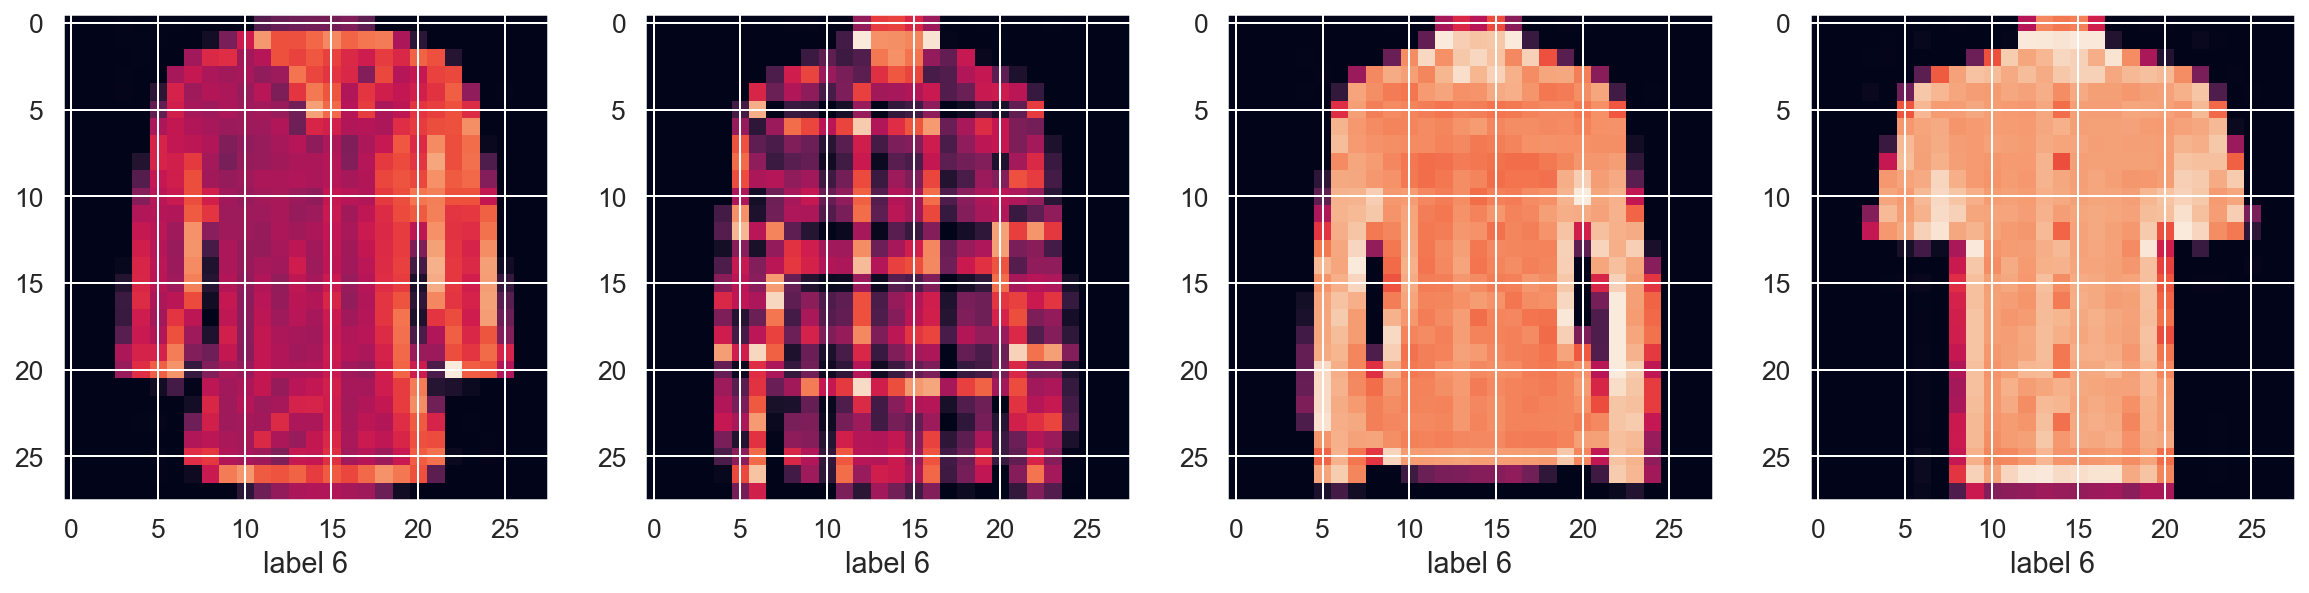

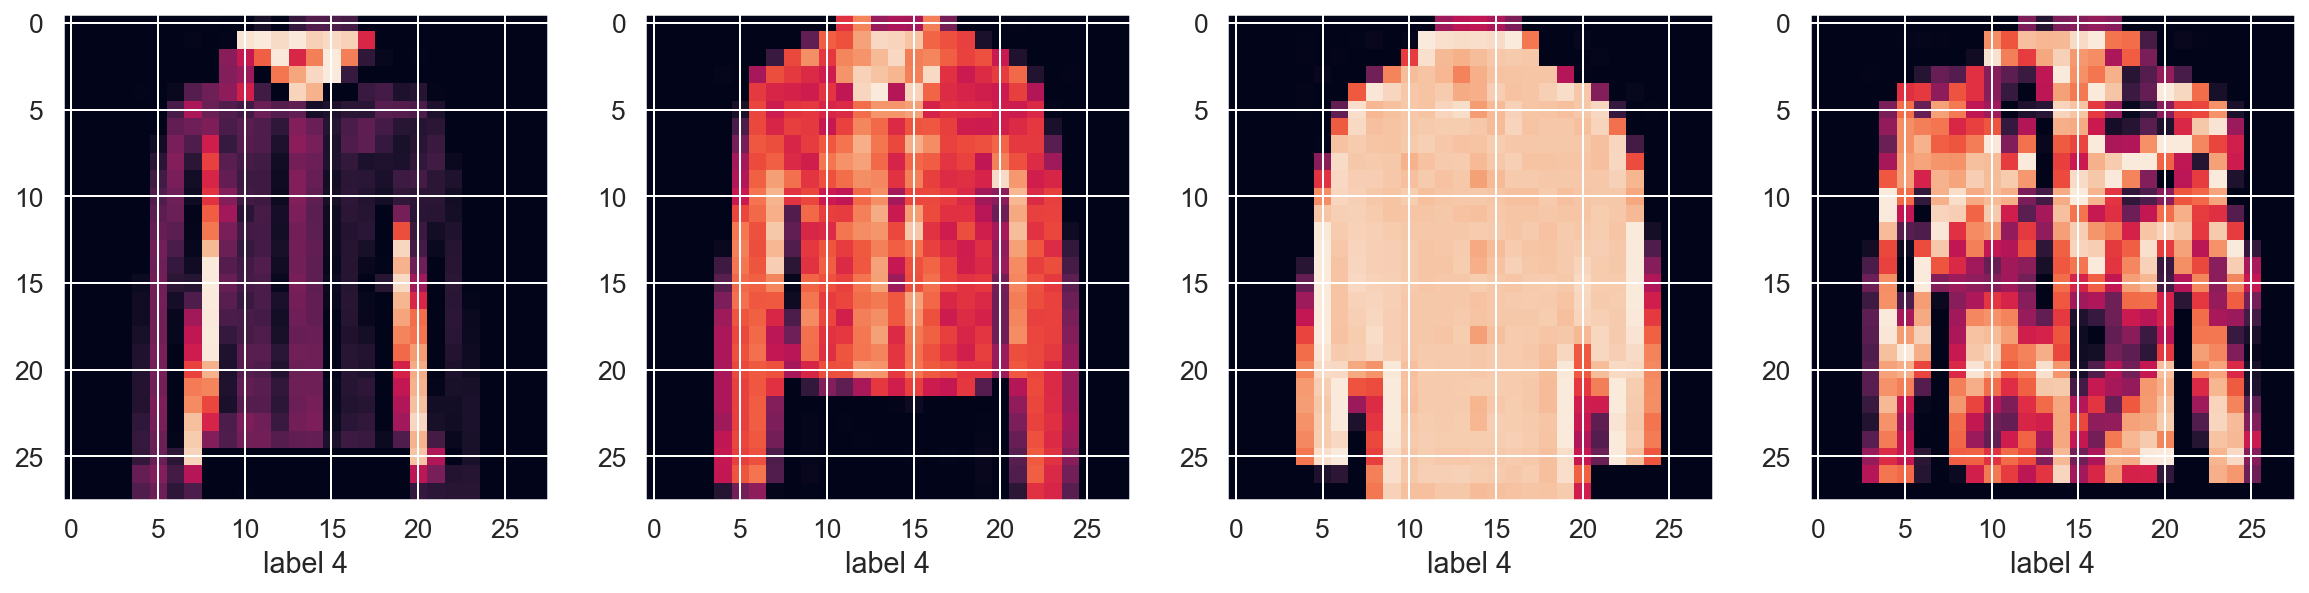

In [71]:
six = []
four = []
for i, label in enumerate(test_labels[:300]): 
    if label == 6:
        six.append(i)       
    elif label == 4:
        four.append(i)   

plt.figure(figsize =(20,5))
for i, label in enumerate(six[:4]):
  plt.subplot(1,4,i+1)
  plt.imshow(test_images[label,:].reshape(28,28))
  plt.xlabel('label '+str(test_labels[label]))
plt.show()  

plt.figure(figsize =(20,5))
for i, label in enumerate(four[:4]):
  plt.subplot(1,4,i+1)
  plt.imshow(test_images[label,:].reshape(28,28))
  plt.xlabel('label '+str(test_labels[label]))
plt.show()  

Наблюдение: вероятно, проблема с предсказанием 6 и 4 классов связана с тем, что картинки в этих двух классах очень похожи друг на друга. Я бы тоже их вряд ли не отличил.